
* Exploratory Data Analysis and Preprocessing for TSLA, BND, and SPY
This notebook loads the processed financial data, visualizes key metrics, checks stationarity, and calculates foundational risk statistics.


# 1. import dependencis

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import sys
import os

# Add the src folder to sys.path so Python can find your modules there
sys.path.append(os.path.abspath("../src"))

print("Current working directory:", os.getcwd())

from preprocessing import adf_test
import data_loader as dl

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


Current working directory: c:\Users\hp\Desktop\10 Acadamy\VS code\portfolio-forecasting-gmf\notebooks


# 2. Load Processed Data
We load the cleaned datasets for Tesla (TSLA), Vanguard Bonds (BND), and S&P 500 ETF (SPY) from `data/processed`.


In [4]:
# File paths
data_path = "../data/processed/"

tickers = ["TSLA", "BND", "SPY"]

dfs = {}
for t in tickers:
    df = pd.read_csv(f"{data_path}{t}_processed.csv", index_col=0, parse_dates=True)
    dfs[t] = df
    print(f"{t}: {df.shape[0]} rows, {df.shape[1]} columns")

TSLA: 2631 rows, 11 columns
BND: 2631 rows, 11 columns
SPY: 2631 rows, 11 columns


# 3. Summary Statistics
Check basic descriptive stats of the adjusted close price and daily returns.

In [5]:
for t in tickers:
    print(f"--- {t} ---")
    print("Adjusted Close Price Statistics:")
    print(dfs[t]["Close"].describe())
    print("\nDaily Return Statistics:")
    print(dfs[t]["Daily_Return"].describe())
    print("\n")

--- TSLA ---
Adjusted Close Price Statistics:
count    2631.000000
mean      132.331943
std       121.366455
min         9.488000
25%        18.924334
50%        95.666664
75%       236.121666
max       475.899994
Name: Close, dtype: float64

Daily Return Statistics:
count    2630.000000
mean        6.331177
std        43.933608
min       -73.868324
25%       -18.364508
50%        -1.303295
75%        18.823484
max       556.860772
Name: Daily_Return, dtype: float64


--- BND ---
Adjusted Close Price Statistics:
count    2631.000000
mean       68.469807
std         4.550900
min        60.786652
25%        64.664054
50%        67.593807
75%        71.865548
max        77.378718
Name: Close, dtype: float64

Daily Return Statistics:
count    2630.000000
mean             inf
std              NaN
min      -100.000000
25%       -18.608626
50%         0.000000
75%        22.429256
max              inf
Name: Daily_Return, dtype: float64


--- SPY ---
Adjusted Close Price Statistics:
count    2

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


# 4. Visualize Adjusted Close Price Over Time
Plot adjusted closing prices to observe overall trends and volatility.


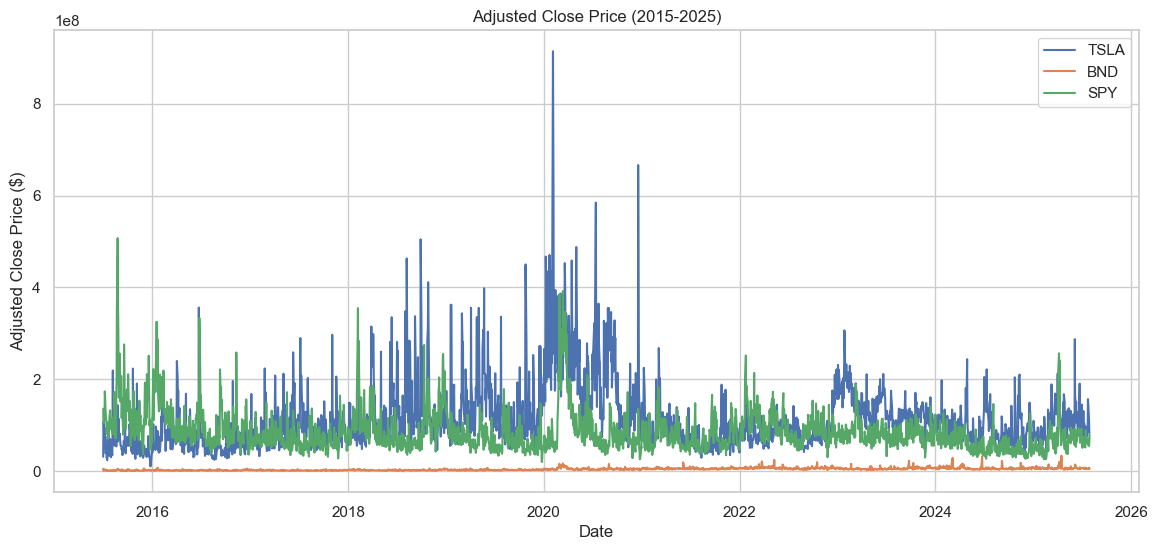

In [6]:
plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(dfs[t].index, dfs[t]["Adj Close"], label=t)
plt.title("Adjusted Close Price (2015-2025)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price ($)")
plt.legend()
plt.show()

# 5. Visualize Daily Returns
Daily percentage change helps understand volatility and market movements.


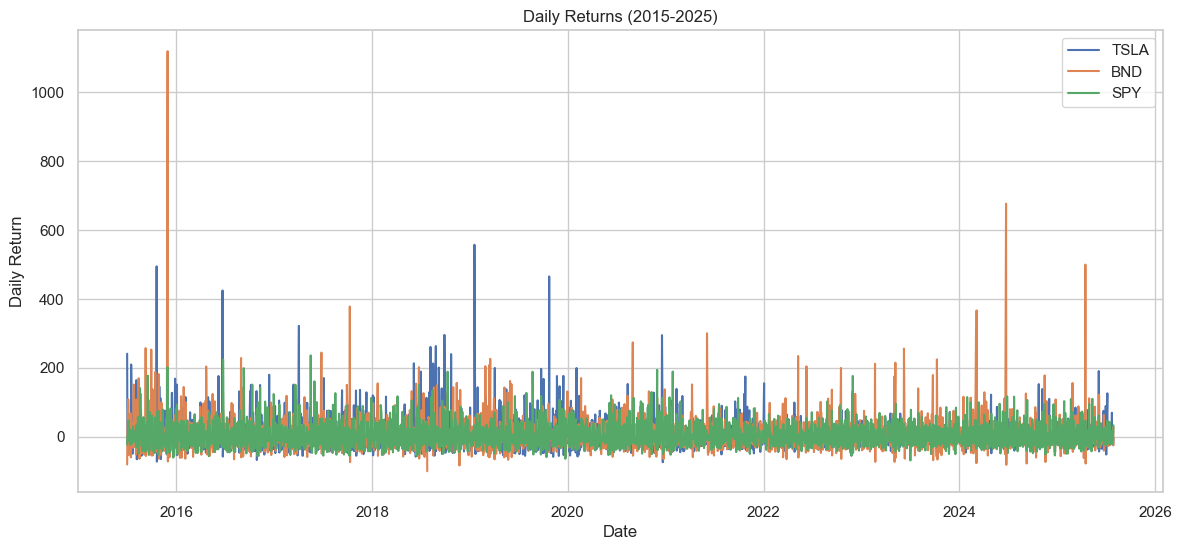

In [7]:
plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(dfs[t].index, dfs[t]["Daily_Return"], label=t)
plt.title("Daily Returns (2015-2025)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

# 6. Rolling Volatility (Annualized)
Calculate and plot 21-day rolling volatility to understand short-term risk.

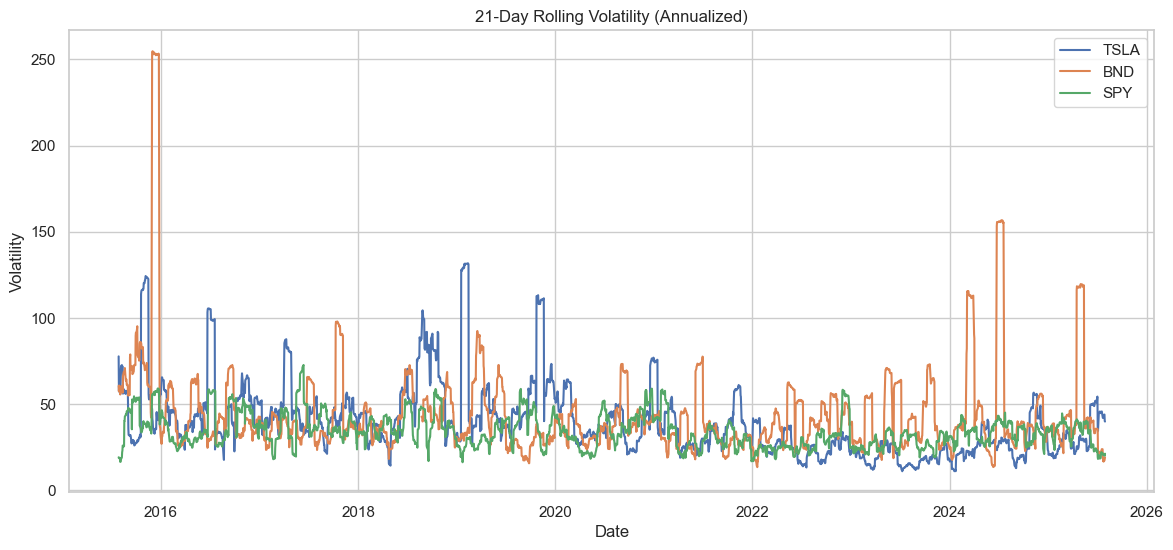

In [8]:
plt.figure(figsize=(14,6))
for t in tickers:
    plt.plot(dfs[t].index, dfs[t]["Rolling_Volatility_20"], label=t)
plt.title("21-Day Rolling Volatility (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# 7. Stationarity Check: Augmented Dickey-Fuller Test
Test if the log-adjusted closing prices are stationary. Stationarity is a key assumption for ARIMA models.

- Null hypothesis (H0): Non-stationary series  
- Alternative hypothesis (H1): Stationary series  
- p-value < 0.05 suggests rejecting H0 → Stationary series


In [9]:
def clean_series(series):
    series = series.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    series = series.dropna()                            # Drop all NaNs
    return series

for t in tickers:
    print(f"Testing differenced log_adjclose for {t}")
    diff_series = dfs[t]["log_adjclose"].diff()
    diff_series = clean_series(diff_series)
    adf_test(diff_series, t + " (diff)")


Testing differenced log_adjclose for TSLA

Augmented Dickey-Fuller Test: TSLA (diff)


ADF Statistic : -17.934008678167842
p-value : 2.876430297454075e-30
# Lags Used : 18
# Observations Used : 2611
Critical Value (1%) : -3.432856986061305
Critical Value (5%) : -2.8626475938238967
Critical Value (10%) : -2.5673596115790938
✅ Strong evidence against null hypothesis (series is stationary)
Testing differenced log_adjclose for BND

Augmented Dickey-Fuller Test: BND (diff)
ADF Statistic : -16.086521421879077
p-value : 5.309108130815286e-29
# Lags Used : 23
# Observations Used : 2604
Critical Value (1%) : -3.432863731932001
Critical Value (5%) : -2.8626505729128096
Critical Value (10%) : -2.5673611976670654
✅ Strong evidence against null hypothesis (series is stationary)
Testing differenced log_adjclose for SPY

Augmented Dickey-Fuller Test: SPY (diff)
ADF Statistic : -14.241365457341983
p-value : 1.5356422666964947e-26
# Lags Used : 28
# Observations Used : 2601
Critical Value (1%) : -3.432866634145742
Critical Value (5%) : -2.8626518545766904
Critical Value (10%) : -2.567361

# 8. Correlation Analysis
Visualize correlation between daily returns of the three assets.


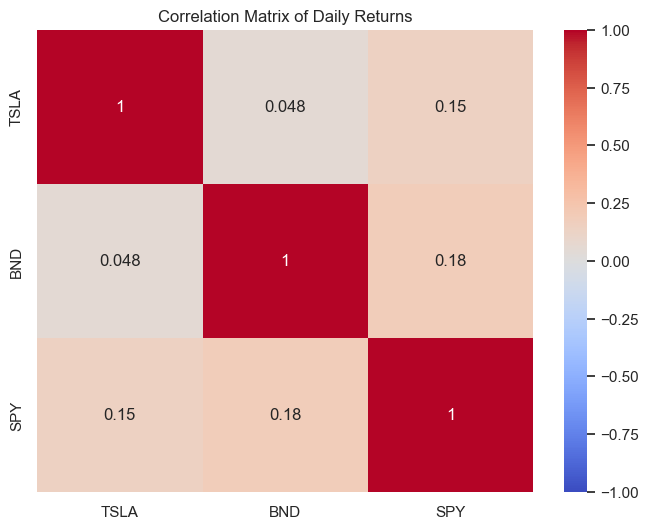

In [10]:
returns_df = pd.DataFrame({t: dfs[t]["Daily_Return"] for t in tickers})
plt.figure(figsize=(8,6))
sns.heatmap(returns_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Returns")
plt.show()


# 9. Risk Metrics: Sharpe Ratio and Value at Risk (VaR)
Calculate these to assess risk and risk-adjusted returns.

- Sharpe Ratio: mean return divided by standard deviation (annualized)  
- VaR (5%): worst expected loss over a given time frame with 95% confidence


In [11]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    """Annualized Sharpe Ratio with thorough NaN/inf cleaning and zero volatility check"""
    returns_clean = returns.replace([np.inf, -np.inf], np.nan).dropna()
    
    if returns_clean.empty:
        print("⚠ Warning: No valid returns data for Sharpe Ratio.")
        return np.nan
    
    std_ret = returns_clean.std()
    if std_ret == 0 or np.isnan(std_ret):
        print(f"⚠ Warning: Std deviation zero or NaN for Sharpe Ratio. Returns sample:\n{returns_clean.head(10)}")
        return np.nan
    
    mean_ret = returns_clean.mean()
    return (mean_ret - risk_free_rate) / std_ret * np.sqrt(252)

def value_at_risk(returns, confidence_level=0.05):
    """Historical VaR with thorough NaN/inf cleaning"""
    returns_clean = returns.replace([np.inf, -np.inf], np.nan).dropna()
    if returns_clean.empty:
        print("⚠ Warning: No valid returns data for VaR.")
        return np.nan
    return np.percentile(returns_clean, 100 * confidence_level)

print("Risk Metrics (Annualized Sharpe Ratio and 5% VaR):")
for t in tickers:
    sr = sharpe_ratio(dfs[t]["Daily_Return"])
    var = value_at_risk(dfs[t]["Daily_Return"])
    print(f"{t}: Sharpe Ratio = {sr}, 5% VaR = {var}")


Risk Metrics (Annualized Sharpe Ratio and 5% VaR):
TSLA: Sharpe Ratio = 2.2876409800260133, 5% VaR = -40.089485090912895
BND: Sharpe Ratio = 2.382154288722178, 5% VaR = -44.471308832663205
SPY: Sharpe Ratio = 2.27833355358596, 5% VaR = -39.32763008441281
